<a href="https://colab.research.google.com/github/Ash100/Trainings/blob/main/MAJU_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WELCOME TO ATTEND "Applications of AI in Drug Discovery" 2024**

##This training Session is Designed by **Dr. Ashfaq Ahmad** for the Participants attending the training session at **Muhammad Ali Jinnah University, MAJU Karachi**.

##I will explain all the steps in Parallel during this training.

In [ ]:
#@title Prerequistite Installation and Import
! pip install chembl_webresource_client
! pip install rdkit-pypi

import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [ ]:
#@title As an example I will use P2Y purinoceptor 1 protein (UniProt Accession P47900)
target = new_client.target
target_query = target.search('CHEMBL4315')
targets = pd.DataFrame.from_dict(target_query)
targets

In [4]:
#@title Lets retrieve Bioactivity Data
selected_target = targets.target_chembl_id[0]
selected_target

'CHEMBL4315'

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
df

In [6]:
#@title Lets Download this initial data
df.to_csv('data_1.csv', index=False)

This data contains many columns. We will be interested in three columns;

i. Compound ID

ii. Compound SIMILES (it is a linear representation of a chemical compound)

iii. Activity value (Normally in IC50 unit)

**Now we are going to remove all other columns - Also we will delete the data with missing values for the above three points.**

In [ ]:
#@title Treating Missing Data
df2 = df[df.standard_value.notna()]
df2 = df[df.canonical_smiles.notna()]

len(df2.canonical_smiles.unique())
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

In [ ]:
#@title Removing the extra columns
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3


In [9]:
#@title Now we are going to save this data
df3.to_csv('Data_2.csv', index=False)

**Compound Labelling**

Now, we will label all the compounds in the dataset into three categories;

i. IC50 value < 1000 --------> **Active**

ii. IC50 value  > 1000 and < 10000 -----------------> **Inactive**

iii. IC50 value > 1000 and < 10000 --------------> **Intermediate**



In [ ]:
#@title Lets starts processing
df4 = pd.read_csv('Data_2.csv')

bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

    bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)


df5

In [11]:
df5.to_csv('Data_3.csv', index=False)

In [12]:
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)

    return x

In [ ]:
df5.standard_value.describe()

In [14]:
-np.log10( (10**-9)* 100000000 )
-np.log10( (10**-9)* 10000000000 )
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)

    return x

In [ ]:
import pandas as pd

# Normalization function
def norm_value(input_df):
    # Normalize the 'standard_value' column
    norm = (input_df['standard_value'] - input_df['standard_value'].min()) / (input_df['standard_value'].max() - input_df['standard_value'].min())
    input_df['standard_value_norm'] = norm
    x = input_df.drop('standard_value', axis=1)
    return x

# Assuming df_combined is already loaded
df_norm = norm_value(df5)
print(df_norm)

In [ ]:
df_norm

In [ ]:
import pandas as pd

# Function to calculate pIC50 values
def pIC50(input_df):
    # Assuming we are calculating pIC50 using the normalized values
    input_df['pIC50'] = -np.log10(input_df['standard_value_norm'] * 1e-9)  # Example transformation
    return input_df

# Assuming df_norm is already created
df_final = pIC50(df_norm)
print(df_final)

In [ ]:
df_final

In [51]:
df_final.to_csv('df_final.csv', index=False)

In [ ]:
#@title Distribution plot
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size and DPI to control resolution
width_pixels = 600
dpi = 100  # For 600 pixels width with a 6-inch figure
width_in_inches = width_pixels / dpi

# Plot Bioactivity class frequency
plt.figure(figsize=(width_in_inches, width_in_inches), dpi=dpi)

sns.countplot(x='class', data=df_final, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

# Show the plot
plt.show()

# Save the plot as a PNG file
plt.savefig("bioactivity_class_frequency.png", format="png", dpi=dpi)
plt.close()


In [19]:
df_final.to_csv('Data_Final.csv')

In [ ]:
#@title Frequency plot
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with specified size
plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(df_combined['pIC50'], kde=True)
plt.title("Distribution of pIC50 Values")
plt.xlabel("pIC50")
plt.ylabel("Frequency")

# Show the plot
plt.show()

# Save the plot as a PNG file
plt.savefig("pIC50_distribution.png", format="png", dpi=100)  # Adjust DPI for resolution as needed
plt.close()


In [ ]:
#@title PIC50 vs Classes
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with specified size
plt.figure(figsize=(12, 6))

# Plot the boxplot
sns.boxplot(data=df_combined, x='class', y='pIC50')
plt.title("pIC50 Across Bioassay Classes")
plt.xlabel("Bioassay Class")
plt.ylabel("pIC50")
plt.xticks(rotation=45)

# Show the plot
plt.show()

# Save the plot as a PNG file
plt.savefig("pIC50_bioassay_classes.png", format="png", dpi=100)  # Adjust DPI for resolution as needed
plt.close()


#### **Compound activity measures**

- **IC50** is the half maximal inhibitory concentration of a drug which indicates how much of a drug is needed to inhibit a biological process by half.
- **pIC50** is the negative logarithm of the IC50 value. It is more easily interpretable than IC50 values and a common measure for potency of compounds.

#### **Molecule encoding**

For machine learning and Artificial Neural Networks algorithms, molecules need to be converted into a machine readable format, e.g. a list of features.

Molecular fingerprints encode chemical structures and molecular features in a bit string, where at each position "1" represents the presence and "0" represents the absence of a feature. One of the common fingerprints used are **M**olecular **ACC**ess **S**ystem fingerprints [(MACCS Keys)](https://docs.eyesopen.com/toolkits/python/graphsimtk/fingerprint.html#maccs) which are 166 bits structural key descriptors in which each bit is associated with a [SMARTS](https://docs.eyesopen.com/toolkits/python/oechemtk/glossary.html#term-smarts) pattern encoding a specific substructure.

#### **What is a neural network?**

Neural networks, also known as artificial neural networks (ANNs), are a subset of machine learning algorithms. The structure and the name of the neural network is inspired by the human brain, mimicking the way that biological neurons transfer signals to one another.

![Basic structure](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network/images/basic_structure.png?raw=1)

*Figure 1:* The figure shows the basic structure of an artificial neural network. It is taken from the blogpost: "*Designing Your Neural Networks*", Lavanya Shukla, [towardsdatascience](https://towardsdatascience.com/designing-your-neural-networks-a5e4617027ed).

ANNs consist of three main layers as shown in the figure above: the _input layer_, some _hidden layers_ and the _output layer_. Let's take a deeper look at each of them.

1. **Input neurons or input layer**
   - This layer represents the number of features which are used to make the predictions.
   - The input vector needs one input neuron per feature.
2. **Hidden layers and neurons per hidden layer**
    - The dimension of the hidden layers may vary greatly, but a good rule of thumb is to have dimensions in the range of the input layer and the output layer.
    - In general, using the same number of neurons for all hidden layers will suffice but for some datasets, having a large first layer and following it up with smaller layers may lead to a better performance as first layers can learn many low-level features.
3. **Output neurons or output layer**
    - The output layer represents the value of interest, which will be predicted by the neural network.
        - Regression task: the value is a real number (or vector) such as the pIC50 value.
        - Binary classification task: the output neuron represents the probability of belonging to the positive class.
        - Multi-class classification task: there is one output neuron per class and the predictions represent the probability of belonging to each class. A certain activation function is applied on the output layer to ensure the final probabilities sum up to 1.

**Neurons** are the core units of a neural network. Let's look into the operations done by each neuron to understand the overall mechanism of a neural network.

![Neuron](https://github.com/volkamerlab/teachopencadd/blob/master/teachopencadd/talktorials/T022_ligand_based_screening_neural_network/images/neuron.png?raw=1)

*Figure 2:* Operations done by a neuron. The figure is taken from the blogpost: "*First neural network for beginners explained (with code)*", Arthur Arnx, [towardsdatascience](https://towardsdatascience.com/first-neural-network-for-beginners-explained-with-code-4cfd37e06eaf).

### Keras workflow

[Keras](https://keras.io/getting_started/) is an open-source library for machine learning and more specifically neural networks. Its API runs on top of the very well-known [tensorflow](https://www.tensorflow.org/) deep learning platform.

Below, we present a common workflow for training a neural network with [keras](https://keras.io/getting_started/).


- **Prepare the data** − Foremost for any machine learning algorithm, we process, filter and select only the required information from the data. Then, the data is split into training and test data sets. The test data is used to evaluate the prediction of the algorithm and to cross check the efficiency of the learning process.


- **Define the model** - In keras, every ANN is represented by keras [models](https://keras.io/api/models/model/#model-class). Keras provides a way to create a model which is called [sequential](https://keras.io/api/models/sequential/). The layers are arranged sequentially where the data flows from one layer to another layer in a given order until the data finally reaches the output layer. Each layer in the ANN can be represented by a *keras layer*.


- **Compile the model** − The compilation is the final step in creating a model. Once the compilation is done, we can move on to the training phase. A _loss function_ and an _optimizer_ are required in the learning phase to define the prediction error and to minimize it, respectively. In the practical part of this talktorial, we use the mean squared error as a loss and the [adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) optimizer, which is a popular version of gradient descent and has shown to give good results in a wide range of problems.

- **Fit the model** - The actual learning process will be done in this phase using the training data set. We can call the [fit()](https://keras.io/api/models/model_training_apis/#fit-method) method which needs several parameters such as $x$ the input data, $y$ the target data, the batch size, the number of epochs, etc. An _epoch_ is when the entire dataset is passed forward and backward through the neural network once.

- **Evaluate model** − We can evaluate the model by looking at the loss function between the predicted and true values of the test data using the [evaluate()](https://keras.io/api/models/model_training_apis/#evaluate-method) method.

    - Scatter plots are a common and simple approach to visualize the evaluation of a model. They plot the predicted vs. true values. If the fit was perfect, we should see the $y=x$ line, meaning that the predicted value is exactly the true value.
    
    
- **Predictions on external/unlabeled data** − We make predictions based on the trained model for the external data set using the [predict()](https://keras.io/api/models/model_training_apis/#predict-method) method.

In [ ]:
#@title Installation of some required packages
! pip install seaborn
! pip install matplotlib
! pip install --upgrade keras
! pip install --upgrade scikit_learn

In [21]:
#@title Import the required libraries
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw, rdFingerprintGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

Our data should contains three columns.

i. Molecular ID

ii. SMILES

iii. pIC50


 How many columns it contains? Lets see

In [22]:
# Load data
df = pd.read_csv("/content/Data_Final-1.csv")
df = df.reset_index(drop=True)

In [23]:
# Look at head
df.head()

,Unnamed: 0,molecule_chembl_id,canonical_smiles,class,standard_value_norm,pIC50
0,0,CHEMBL133572,Nc1c(S(=O)(=O)[O-])cc(Nc2ccc(Nc3nc(Cl)nc(Cl)n3...,active,0.000550,12.260009
1,1,CHEMBL133576,Cc1cc(C)c(Nc2cc(S(=O)(=O)[O-])c(N)c3c2C(=O)c2c...,intermediate,0.001649,11.782882
2,2,CHEMBL356041,CNc1nc([Se]C)nc2c1ncn2C1CC(OP(=O)(O)O)[C@]2(CO...,active,0.000207,12.683682
3,3,CHEMBL2112869,CCCCCCc1nc(NC)c2ncn([C@H]3C[C@H](OP(=O)(O)O)[C...,active,0.000248,12.604881
4,4,CHEMBL2112868,CNc1nc(F)nc2c1ncn2[C@H]1C[C@H](OP(=O)(O)O)[C@]...,active,0.000196,12.708574


In [25]:
# Keep necessary columns
chembl_df = df[["canonical_smiles", "pIC50"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,canonical_smiles,pIC50
0,Nc1c(S(=O)(=O)[O-])cc(Nc2ccc(Nc3nc(Cl)nc(Cl)n3...,12.260009
1,Cc1cc(C)c(Nc2cc(S(=O)(=O)[O-])c(N)c3c2C(=O)c2c...,11.782882
2,CNc1nc([Se]C)nc2c1ncn2C1CC(OP(=O)(O)O)[C@]2(CO...,12.683682
3,CCCCCCc1nc(NC)c2ncn([C@H]3C[C@H](OP(=O)(O)O)[C...,12.604881
4,CNc1nc(F)nc2c1ncn2[C@H]1C[C@H](OP(=O)(O)O)[C@]...,12.708574


In [26]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetCountFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetCountFingerprint(mol))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [27]:
chembl_df["fingerprints_df"] = chembl_df["canonical_smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe:", chembl_df.shape)
chembl_df.head(3)
# NBVAL_CHECK_OUTPUT

Shape of dataframe: (222, 3)


,canonical_smiles,pIC50,fingerprints_df
0,Nc1c(S(=O)(=O)[O-])cc(Nc2ccc(Nc3nc(Cl)nc(Cl)n3...,12.260009,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Cc1cc(C)c(Nc2cc(S(=O)(=O)[O-])c(N)c3c2C(=O)c2c...,11.782882,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CNc1nc([Se]C)nc2c1ncn2C1CC(OP(=O)(O)O)[C@]2(CO...,12.683682,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [28]:
#@title Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50"]], test_size=0.2, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

Shape of training data: (177,)
Shape of test data: (45,)


In [29]:
#@title Step-1: Define and Compile Neural Network Model
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer3"))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

In [30]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

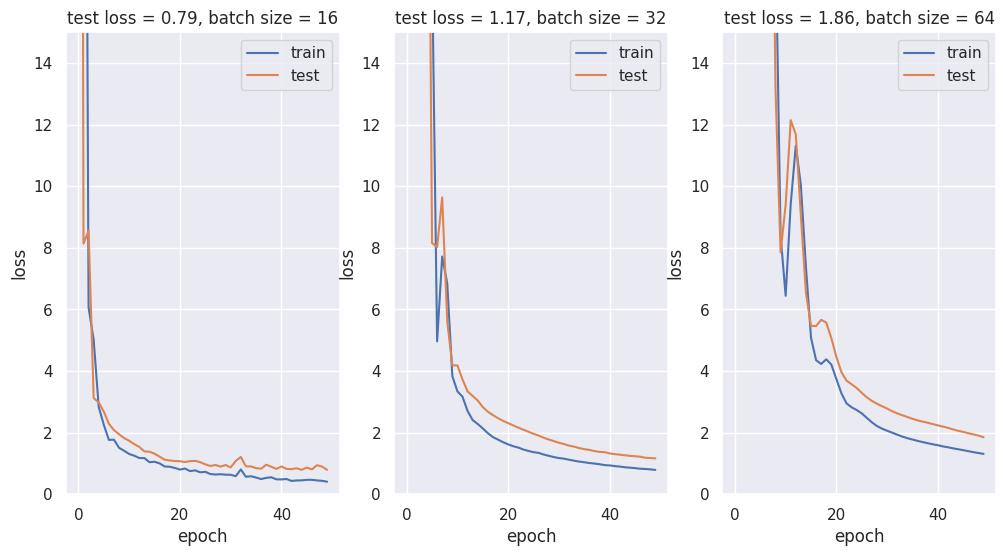

In [31]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))).astype(float),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()

In [32]:
from keras.callbacks import ModelCheckpoint
import numpy as np

# Save the trained model
filepath = "/content/sample_data/best_weights.weights.h5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

In [33]:
#@title Model Evaluation
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

Evaluate the model on the test data
 loss: 0.99
 mse (same as loss): 0.99
 mae: 0.75


In [34]:
#@title training and Prediction of pIC50 values on x_test data
y_pred = model.predict(np.array(list((x_test))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
11.65
12.08
13.41
14.40
11.68


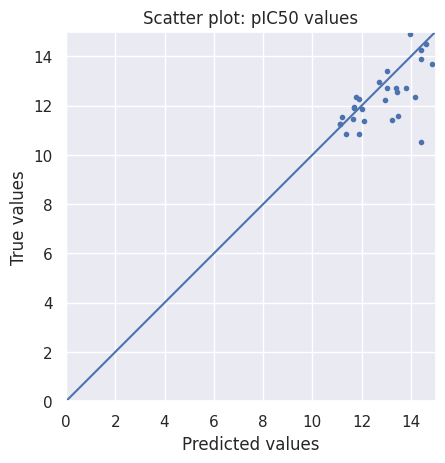

In [35]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot: pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.show()

In [36]:
from keras.models import model_from_json

# Serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [38]:
#@title Upload Unknown Dataset
external_data = pd.read_csv("/content/unk.csv", index_col=0)
external_data = external_data.reset_index(drop=False)
external_data.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,canonical_smiles
0,Metformin,CN(C)C(=N)N=C(N)N
1,Paracetamol,CC(=O)NC1=CC=C(C=C1)O
2,Brufen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O


In [39]:
# Convert SMILES strings to MACCS fingerprints
external_data["fingerprints_df"] = external_data["canonical_smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe : ", external_data.shape)
external_data.head(3)
# NBVAL_CHECK_OUTPUT

Shape of dataframe :  (3, 3)


,molecule_chembl_id,canonical_smiles,fingerprints_df
0,Metformin,CN(C)C(=N)N=C(N)N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Paracetamol,CC(=O)NC1=CC=C(C=C1)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Brufen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [40]:
# load json and create model
json_file = open("model.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [41]:
#@title Perform Predictions on Unknown Data
predictions = model.predict(
    np.array(list((external_data["fingerprints_df"]))).astype(float), callbacks=callbacks_list
)

predicted_pIC50 = pd.DataFrame(predictions, columns=["predicted_pIC50"])
predicted_pIC50_df = external_data.join(predicted_pIC50)

predicted_pIC50_df.head(4)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


,molecule_chembl_id,canonical_smiles,fingerprints_df,predicted_pIC50
0,Metformin,CN(C)C(=N)N=C(N)N,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.475342
1,Paracetamol,CC(=O)NC1=CC=C(C=C1)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7.245129
2,Brufen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5.453780


In [ ]:
# Save the predicted values in a csv file in the data folder
predicted_pIC50_df.to_csv("/content/predictions.csv")

#**CONGRATULATIONS FOR COMPLETING THIS SHORT TUTORIAL**


#In Case You Want To Learn With Me, I Drop Interesting Tutorials on

#**BIOINFORMATICS INSIGHTS** A YOUTUBE CHANNEL